In [7]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# torch.cuda.device_count()
torch.cuda.current_device()

0

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install transformers;

In [3]:
import torch
from transformers import BertTokenizer, BertModel

In [4]:
# Used the uncased BERT over the cased version because the uncased BERT has a larger vocabulary size. 
# Additionally, the BERT tokenizer includes tokens to identify the beginning and ending of sentences. 
# Also It is less likely for models to generate all CAPS letters or mistakenly generate vocabulary that should have the first letter capitalized (assumption).

bertTokenizer = BertTokenizer.from_pretrained('bert-base-uncased'); # Load Vocab
bertModel = BertModel.from_pretrained('bert-base-uncased'); # Load Weights

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [5]:
bertModel.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.43.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [6]:
bertParams = list(bertModel.named_parameters())
for i, (name, param) in enumerate(bertParams):
    print(f"Idx: {i:<5} Name: {name:<60} Shape: {tuple(param.size())}")

Idx: 0     Name: embeddings.word_embeddings.weight                            Shape: (30522, 768)
Idx: 1     Name: embeddings.position_embeddings.weight                        Shape: (512, 768)
Idx: 2     Name: embeddings.token_type_embeddings.weight                      Shape: (2, 768)
Idx: 3     Name: embeddings.LayerNorm.weight                                  Shape: (768,)
Idx: 4     Name: embeddings.LayerNorm.bias                                    Shape: (768,)
Idx: 5     Name: encoder.layer.0.attention.self.query.weight                  Shape: (768, 768)
Idx: 6     Name: encoder.layer.0.attention.self.query.bias                    Shape: (768,)
Idx: 7     Name: encoder.layer.0.attention.self.key.weight                    Shape: (768, 768)
Idx: 8     Name: encoder.layer.0.attention.self.key.bias                      Shape: (768,)
Idx: 9     Name: encoder.layer.0.attention.self.value.weight                  Shape: (768, 768)
Idx: 10    Name: encoder.layer.0.attention.self.value.bi

In [7]:
bertModel.pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [8]:
bertTokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [9]:
import pandas as pd
training_data = pd.read_csv('./Data/train.csv')
testing_data = pd.read_csv('./Data/test.csv')
training_data.head(3)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [10]:
def update_max_tokens(token_length, idx, key):
    if token_length > token_stats[key]['tokens']:
        token_stats[key] = {'tokens': token_length, 'index': idx}
        
# Track token counts and indices
token_stats = {
    'max_tokens_prompt': {'tokens': 0, 'index': -1},
    'max_tokens_response_a': {'tokens': 0, 'index': -1},
    'max_tokens_response_b': {'tokens': 0, 'index': -1},
    'max_combined_tokens': {'tokens': 0, 'index': -1},
    'violate_num_tokens': 0  # Counter for sequences exceeding 512 tokens
}

combined_data = pd.concat([training_data, testing_data], ignore_index=True)
for idx, row in combined_data.iterrows():
    prompt_length = len(bertTokenizer.tokenize(row['prompt']))
    response_a_length = len(bertTokenizer.tokenize(row['response_a']))
    response_b_length = len(bertTokenizer.tokenize(row['response_b']))
    
    update_max_tokens(prompt_length, idx, 'max_tokens_prompt')
    update_max_tokens(response_a_length, idx, 'max_tokens_response_a')
    update_max_tokens(response_b_length, idx, 'max_tokens_response_b')
    
    combined_length = prompt_length + response_a_length + response_b_length    
    # Check if the combined number of tokens exceeds the maximum sequence length
    if combined_length > 512:
        token_stats['violate_num_tokens'] += 1
    update_max_tokens(combined_length, idx, 'max_combined_tokens')

In [11]:
tokens_results = pd.DataFrame({
    'Type': ['Prompt', 'Response_a', 'Response_b', 'Combined Text'],
    'Max_Tokens': [
        token_stats['max_tokens_prompt']['tokens'],
        token_stats['max_tokens_response_a']['tokens'],
        token_stats['max_tokens_response_b']['tokens'],
        token_stats['max_combined_tokens']['tokens']
    ],
    'Index': [
        token_stats['max_tokens_prompt']['index'],
        token_stats['max_tokens_response_a']['index'],
        token_stats['max_tokens_response_b']['index'],
        token_stats['max_combined_tokens']['index']
    ],
    '#Rows_Exceeding 512 tokens': [
        '--', '--', '--',
        token_stats['violate_num_tokens']
    ]
})

print(tokens_results)

            Type  Max_Tokens  Index #Rows_Exceeding 512 tokens
0         Prompt        9764  34391                         --
1     Response_a       24586  46908                         --
2     Response_b       19955  56716                         --
3  Combined Text       43810  46908                      33515


In [12]:
llms = set(training_data['model_a']).union(set(training_data['model_b']))
llms_stats = {model: {'wins': 0, 'ties': 0, 'non_wins': 0} for model in llms}

for _, row in training_data.iterrows():
    model_a = row['model_a']
    model_b = row['model_b']
    
    if row['winner_model_a']:
        llms_stats[model_a]['wins'] += 1
        llms_stats[model_b]['non_wins'] += 1
    elif row['winner_model_b']:
        llms_stats[model_b]['wins'] += 1
        llms_stats[model_a]['non_wins'] += 1
    elif row['winner_tie']:
        llms_stats[model_a]['ties'] += 1
        llms_stats[model_b]['ties'] += 1

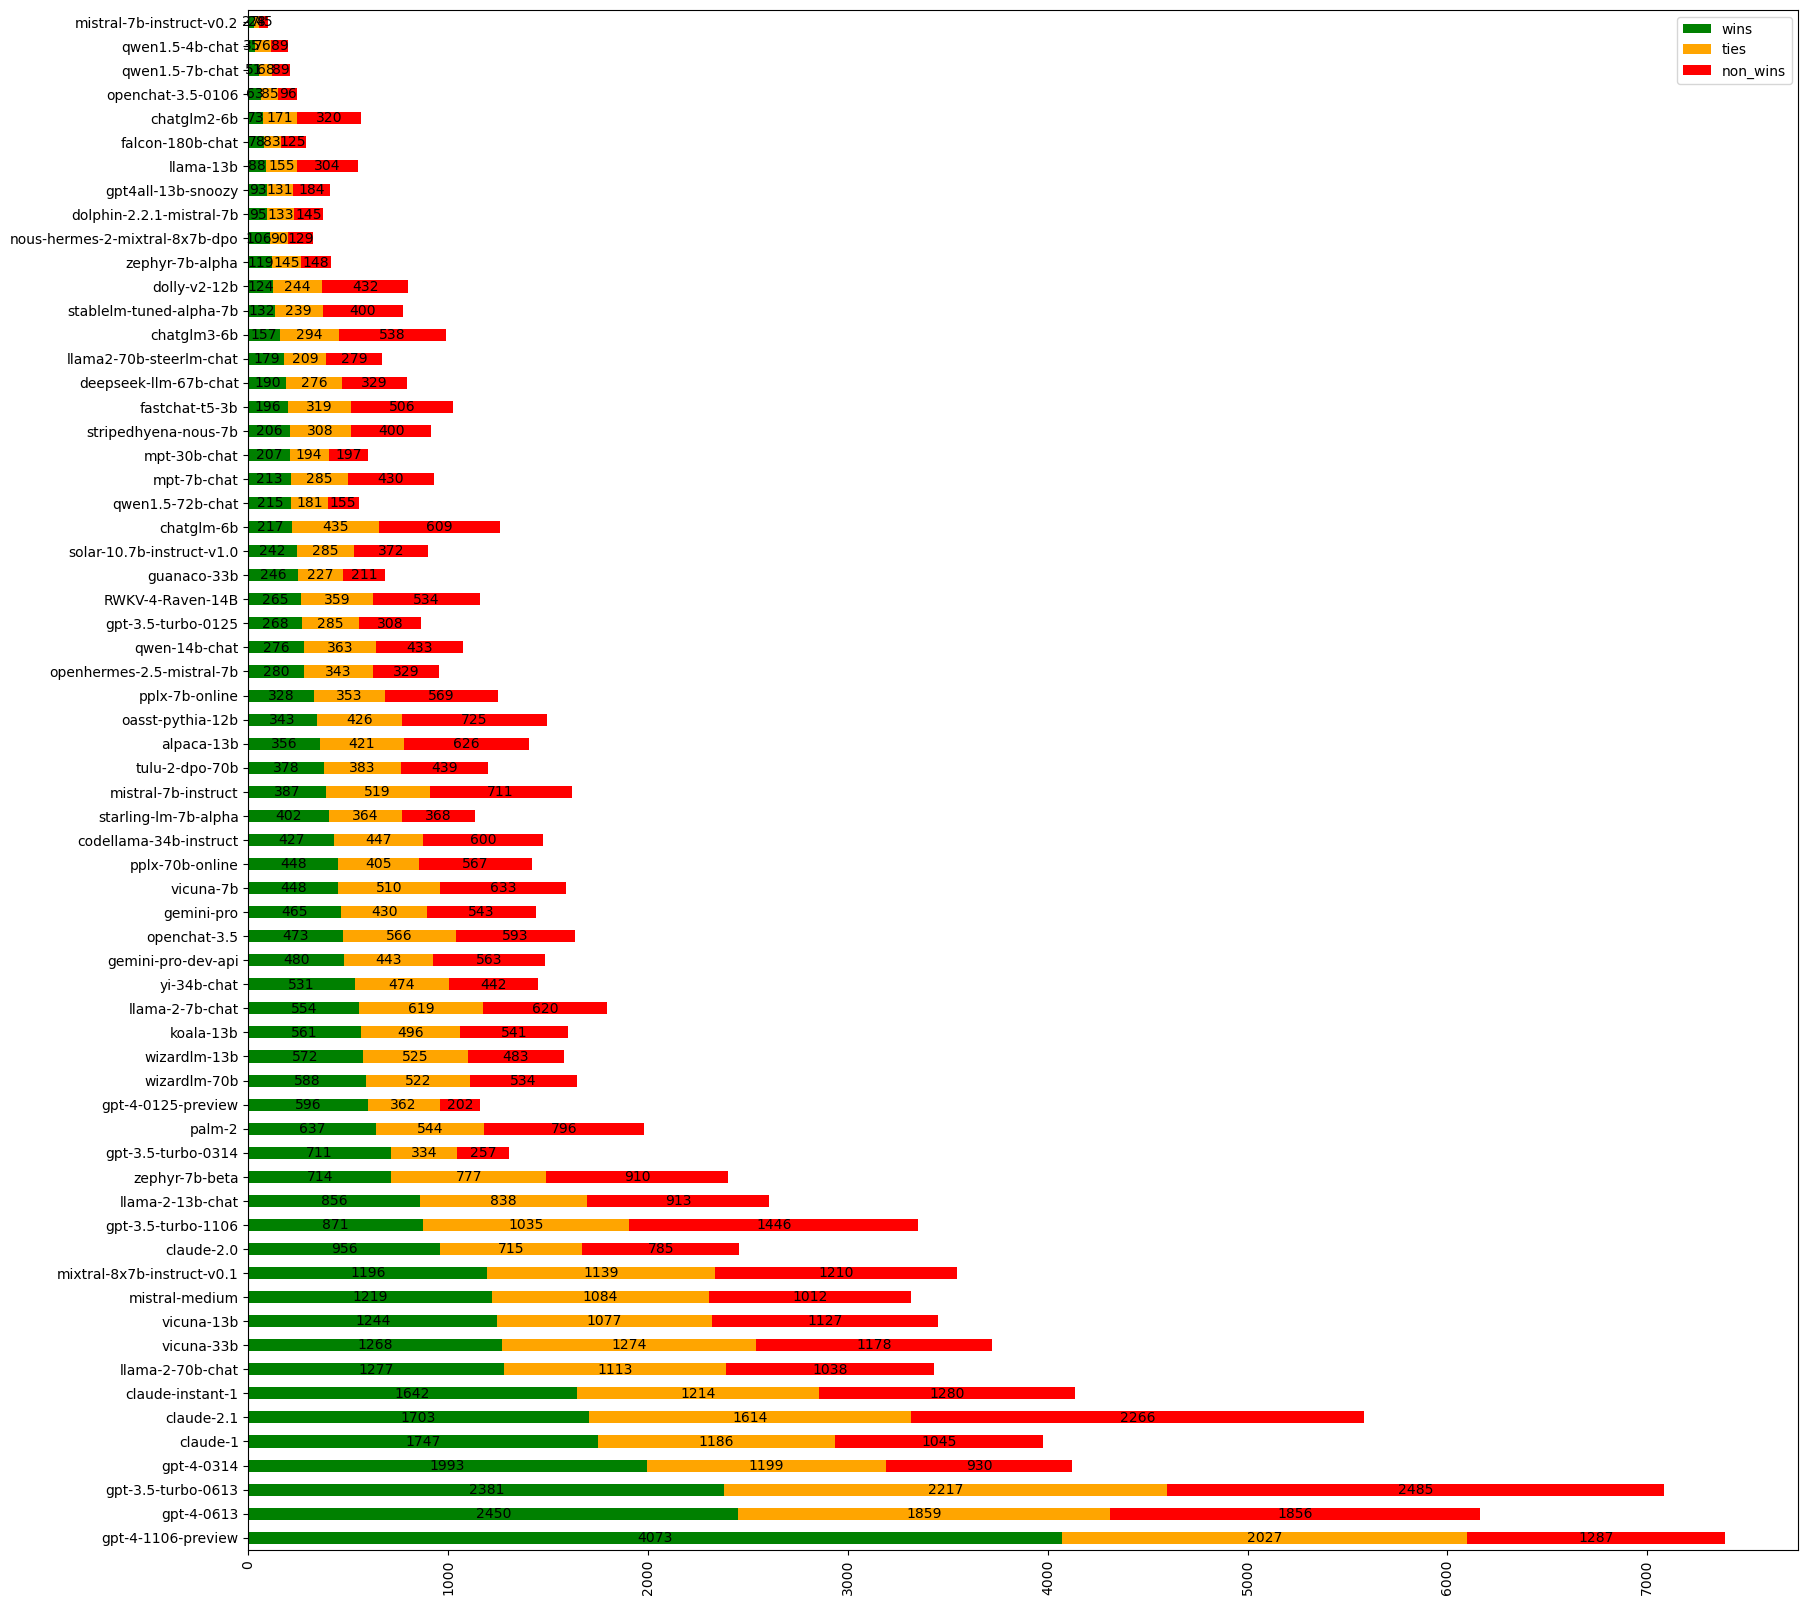

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

llms_result = pd.DataFrame(llms_stats).T
ax = llms_result.sort_values(by='wins', ascending=False, inplace=True)
ax = llms_result.plot(kind='barh', stacked=True, figsize=(20, 20), color=['green', 'orange', 'red'])
for container in ax.containers:
    ax.bar_label(container, label_type='center')
    
plt.xticks(rotation=90)
plt.show()

In [14]:
llms_result.head(12)

,wins,ties,non_wins
gpt-4-1106-preview,4073,2027,1287
gpt-4-0613,2450,1859,1856
gpt-3.5-turbo-0613,2381,2217,2485
gpt-4-0314,1993,1199,930
claude-1,1747,1186,1045
claude-2.1,1703,1614,2266
claude-instant-1,1642,1214,1280
llama-2-70b-chat,1277,1113,1038
vicuna-33b,1268,1274,1178
vicuna-13b,1244,1077,1127


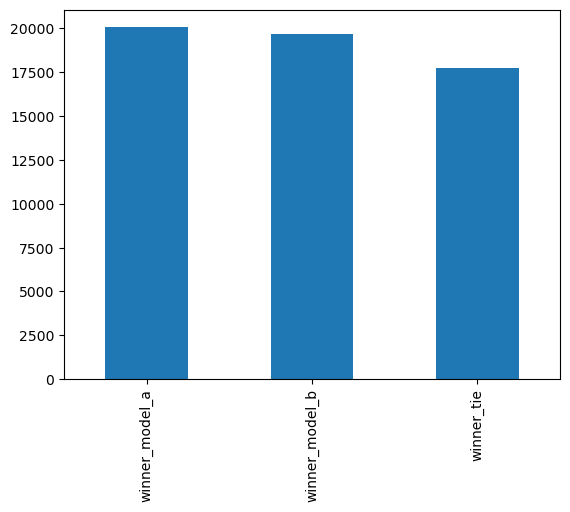

In [17]:
training_data[['winner_model_a', 'winner_model_b', 'winner_tie']].sum().plot(kind='bar')
plt.show()

In [47]:
def determine_preference(row):
    if row['winner_model_a'] == 1:
        return 0
    elif row['winner_model_b'] == 1:
        return 1 
    elif row['winner_tie'] == 1:
        return 2
    else:
        return -1  # Invalid data

training_data['preferred'] = training_data.apply(determine_preference, axis=1)

In [24]:
(training_data['preferred'] == -1).sum()

0

In [25]:
training_data.head(4)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,preferred
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0,0


In [27]:
from transformers import BertTokenizerFast

bertTokenizerFast = BertTokenizerFast.from_pretrained('bert-base-uncased')

def preprocess(data):
    inputs = []
    labels = []

    for _, row in data.iterrows():
        encoded_input_a = bertTokenizerFast.encode_plus(
            row['prompt'], row['response_a'],
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_overflowing_tokens=True,
            return_tensors='pt'
        )
        
        encoded_input_b = bertTokenizerFast.encode_plus(
            row['prompt'], row['response_b'],
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_overflowing_tokens=True,
            return_tensors='pt'
        )

        inputs.append((encoded_input_a, encoded_input_b))
        labels.append(row['preferred'])
    
    return inputs, labels


inputs, labels = preprocess(training_data)

In [37]:
dataset = training_data[['prompt', 'response_a', 'response_b', 'preferred']]

In [38]:
from transformers import BertForSequenceClassification, BertConfig

config = BertConfig.from_pretrained('bert-base-uncased');
config.num_labels = 3
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config);

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [45]:
!pip install transformers[torch]
!pip install accelerate -U;

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [46]:
from transformers import Trainer, TrainingArguments

class PreferenceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        input_a, input_b = self.encodings[idx]
        item = {
            'input_ids_a': input_a['input_ids'].squeeze(),
            'attention_mask_a': input_a['attention_mask'].squeeze(),
            'token_type_ids_a': input_a['token_type_ids'].squeeze(),
            'input_ids_b': input_b['input_ids'].squeeze(),
            'attention_mask_b': input_b['attention_mask'].squeeze(),
            'token_type_ids_b': input_b['token_type_ids'].squeeze(),
            'labels': torch.tensor(self.labels[idx])
        }
        return item

    def __len__(self):
        return len(self.labels)

def convert_to_dict(inputs):
    input_ids = []
    attention_mask = []
    token_type_ids = []

    for input in inputs:
        input_ids.append(input['input_ids'])
        attention_mask.append(input['attention_mask'])
        token_type_ids.append(input['token_type_ids'])

    return {
        'input_ids': torch.cat(input_ids, dim=0),
        'attention_mask': torch.cat(attention_mask, dim=0),
        'token_type_ids': torch.cat(token_type_ids, dim=0)
    }

# Prepare dataset
encodings = convert_to_dict([item for sublist in inputs for item in sublist])
dataset = PreferenceDataset(encodings, labels)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
)

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
trainer.evaluate()

In [ ]:
trainer.train()